**Bias correction of numerical prediction model temperature forecast Data Set**

Com base no dataset Bias correction of numerical prediction model temperature forecast Data Set (https://archive.ics.uci.edu/ml/datasets/Bias+correction+of+numerical+prediction+model+temperature+forecast) da UCI, esse notebook tem o objetivo de fazer uma análise descritiva e avaliação de um modelo de Machine Learning para fazer a estimação da variável Next_Tmax



In [ ]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    cross_val_predict,
)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix,mean_absolute_error
from sklearn.datasets import make_regression
import sklearn.metrics
from itertools import combinations
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import warnings
import folium
from folium import plugins
from folium.plugins import HeatMap




# Notebook Settings
sns.set()
warnings.filterwarnings("ignore") 
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = [18, 17]

In [ ]:
#Vamos usar o geopandas para visualizas os dados espacialmente
%pip install geopandas
import geopandas

In [ ]:
dataset = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00514/Bias_correction_ucl.csv')



**1. Análise Exploratória dos Dados**

In [ ]:
#Visualização Geral do dataset
dataset.head()

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,2013-06-30,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,0.203896,0.161697,0.130928,0.0,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2
1,2.0,2013-06-30,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,0.251771,0.159444,0.127727,0.0,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5
2,3.0,2013-06-30,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,0.257469,0.204091,0.142125,0.0,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9
3,4.0,2013-06-30,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,0.226002,0.161157,0.134249,0.0,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3
4,5.0,2013-06-30,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,0.249995,0.178892,0.170021,0.0,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5


## Attribute Information:

For more information, read [Cho et al, 2020].
1. station - used weather station number: 1 to 25
2. Date - Present day: yyyy-mm-dd ('2013-06-30' to '2017-08-30')
3. Present_Tmax - Maximum air temperature between 0 and 21 h on the present day (Â°C): 20 to 37.6
4. Present_Tmin - Minimum air temperature between 0 and 21 h on the present day (Â°C): 11.3 to 29.9
5. LDAPS_RHmin - LDAPS model forecast of next-day minimum relative humidity (%): 19.8 to 98.5
6. LDAPS_RHmax - LDAPS model forecast of next-day maximum relative humidity (%): 58.9 to 100
7. LDAPS_Tmax_lapse - LDAPS model forecast of next-day maximum air temperature applied lapse rate (Â°C): 17.6 to 38.5
8. LDAPS_Tmin_lapse - LDAPS model forecast of next-day minimum air temperature applied lapse rate (Â°C): 14.3 to 29.6
9. LDAPS_WS - LDAPS model forecast of next-day average wind speed (m/s): 2.9 to 21.9
10. LDAPS_LH - LDAPS model forecast of next-day average latent heat flux (W/m2): -13.6 to 213.4
11. LDAPS_CC1 - LDAPS model forecast of next-day 1st 6-hour split average cloud cover (0-5 h) (%): 0 to 0.97
12. LDAPS_CC2 - LDAPS model forecast of next-day 2nd 6-hour split average cloud cover (6-11 h) (%): 0 to 0.97
13. LDAPS_CC3 - LDAPS model forecast of next-day 3rd 6-hour split average cloud cover (12-17 h) (%): 0 to 0.98
14. LDAPS_CC4 - LDAPS model forecast of next-day 4th 6-hour split average cloud cover (18-23 h) (%): 0 to 0.97
15. LDAPS_PPT1 - LDAPS model forecast of next-day 1st 6-hour split average precipitation (0-5 h) (%): 0 to 23.7
16. LDAPS_PPT2 - LDAPS model forecast of next-day 2nd 6-hour split average precipitation (6-11 h) (%): 0 to 21.6
17. LDAPS_PPT3 - LDAPS model forecast of next-day 3rd 6-hour split average precipitation (12-17 h) (%): 0 to 15.8
18. LDAPS_PPT4 - LDAPS model forecast of next-day 4th 6-hour split average precipitation (18-23 h) (%): 0 to 16.7
19. lat - Latitude (Â°): 37.456 to 37.645
20. lon - Longitude (Â°): 126.826 to 127.135
21. DEM - Elevation (m): 12.4 to 212.3
22. Slope - Slope (Â°): 0.1 to 5.2
23. Solar radiation - Daily incoming solar radiation (wh/m2): 4329.5 to 5992.9
24. Next_Tmax - The next-day maximum air temperature (Â°C): 17.4 to 38.9
25. Next_Tmin - The next-day minimum air temperature (Â°C): 11.3 to 29.8

In [ ]:
#Dataset pequenos; Sem problemas em usar o pandas (Single Node)
dataset.shape

(7752, 25)

In [ ]:
#Todas as variáveis são float com exceção das datas que vamos tratar
dataset.dtypes

station             float64
Date                 object
Present_Tmax        float64
Present_Tmin        float64
LDAPS_RHmin         float64
LDAPS_RHmax         float64
LDAPS_Tmax_lapse    float64
LDAPS_Tmin_lapse    float64
LDAPS_WS            float64
LDAPS_LH            float64
LDAPS_CC1           float64
LDAPS_CC2           float64
LDAPS_CC3           float64
LDAPS_CC4           float64
LDAPS_PPT1          float64
LDAPS_PPT2          float64
LDAPS_PPT3          float64
LDAPS_PPT4          float64
lat                 float64
lon                 float64
DEM                 float64
Slope               float64
Solar radiation     float64
Next_Tmax           float64
Next_Tmin           float64
dtype: object

In [ ]:
#Vamos tratar a data com o formato de data e a estação como uma variável categórica, já que o valor numérico 1>2 não tem significância no caso.
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset['station'] = dataset['station'].astype('category')
dataset.dtypes

station                   category
Date                datetime64[ns]
Present_Tmax               float64
Present_Tmin               float64
LDAPS_RHmin                float64
LDAPS_RHmax                float64
LDAPS_Tmax_lapse           float64
LDAPS_Tmin_lapse           float64
LDAPS_WS                   float64
LDAPS_LH                   float64
LDAPS_CC1                  float64
LDAPS_CC2                  float64
LDAPS_CC3                  float64
LDAPS_CC4                  float64
LDAPS_PPT1                 float64
LDAPS_PPT2                 float64
LDAPS_PPT3                 float64
LDAPS_PPT4                 float64
lat                        float64
lon                        float64
DEM                        float64
Slope                      float64
Solar radiation            float64
Next_Tmax                  float64
Next_Tmin                  float64
dtype: object

In [ ]:
#Vamos observar quantas vezes cada estação aparece
dataset['station'].value_counts()

1.0     310
14.0    310
24.0    310
23.0    310
22.0    310
21.0    310
20.0    310
19.0    310
18.0    310
17.0    310
16.0    310
15.0    310
13.0    310
2.0     310
12.0    310
11.0    310
10.0    310
9.0     310
8.0     310
7.0     310
6.0     310
5.0     310
4.0     310
3.0     310
25.0    310
Name: station, dtype: int64

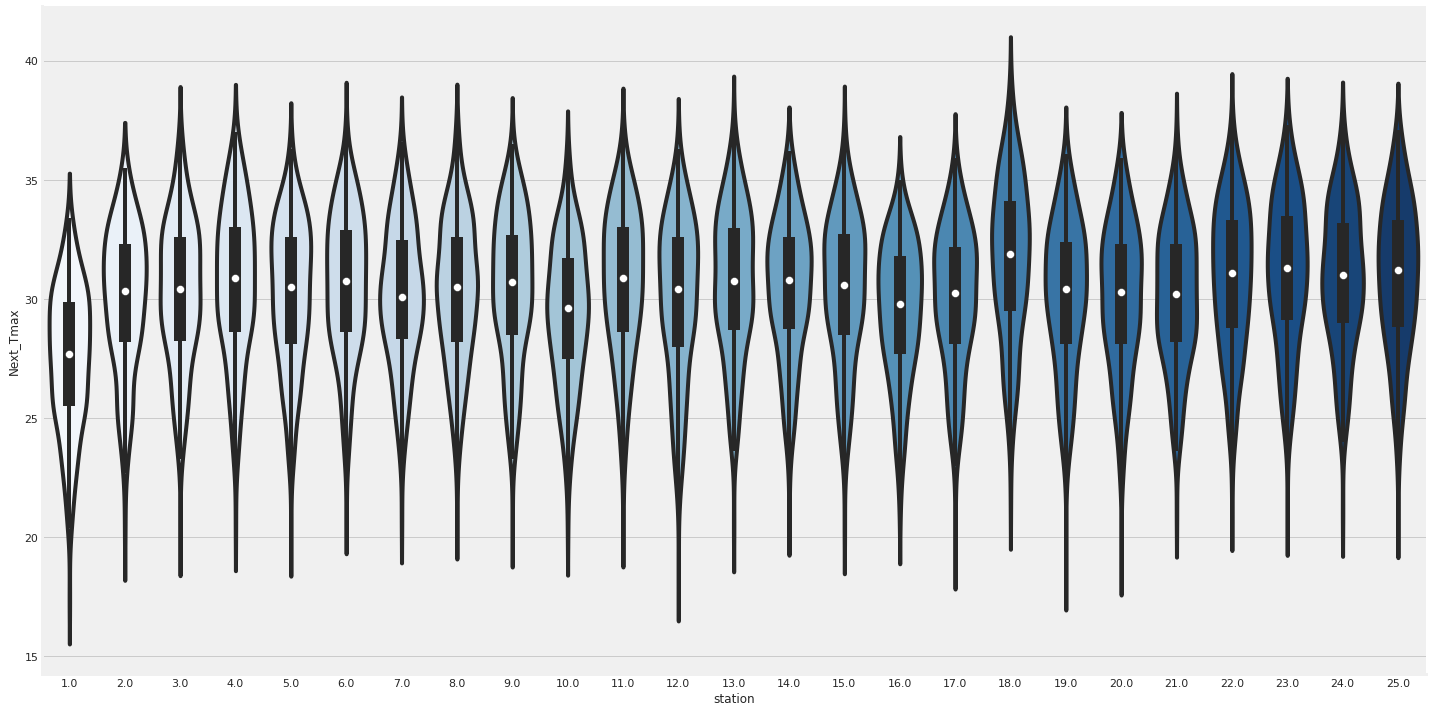

In [ ]:
#Vamos observar como os dados de Next_Tmax estão distribuídos com base nas estações

sns.catplot(data=dataset, x="station", y="Next_Tmax", kind="violin", palette='Blues',height=10, aspect=2)

Podemos notar uma variabilidade que pode ser importante entre as estações, dependendo da sensibilidade de nossa aplicação. Vamos visualizar espacialmente as estações para entender melhor sua distribuição geográfica.

In [ ]:
# Manter as estações x Next_Tmax
df = dataset.loc[:, ("station","Next_Tmax","Date","lat", "lon")]
df["station"] = df["station"].astype('str')

In [ ]:
# Criar as geometrias dos pontos das estações
geometry = geopandas.points_from_xy(df.lon, df.lat)
geo_df = geopandas.GeoDataFrame(df[["station","Next_Tmax","Date","lat", "lon"]], geometry=geometry)

geo_df.head()

,station,Next_Tmax,Date,lat,lon,geometry
0,1.0,29.1,2013-06-30,37.6046,126.991,POINT (126.99100 37.60460)
1,2.0,30.5,2013-06-30,37.6046,127.032,POINT (127.03200 37.60460)
2,3.0,31.1,2013-06-30,37.5776,127.058,POINT (127.05800 37.57760)
3,4.0,31.7,2013-06-30,37.6450,127.022,POINT (127.02200 37.64500)
4,5.0,31.2,2013-06-30,37.5507,127.135,POINT (127.13500 37.55070)


In [ ]:
#Vamos utilizar o folium para visualizar as estações

m = folium.Map(location=[geo_df['lat'][0], geo_df['lon'][0]], zoom_start=11, tiles='CartoDB positron')


# Adicionando a marcação das 25 estações
for i in range(25):
   folium.Marker(
      location=[geo_df.iloc[i]['lat'], geo_df.iloc[i]['lon']],
      popup=geo_df.iloc[i]['station'],
   ).add_to(m)


#Para usar o mapa de calor do Folium, precisamos converter nossa variável estudada
geo_df2 = geo_df.drop(["station","Date"],axis=1)
geo_df2['Next_Tmax'] = geo_df2['Next_Tmax'] / geo_df2['Next_Tmax'].sum()
geo_df2.head()

# Gerando o dataset para podermos fazer o mapa de calor
heat_data = [[row['lat'],row['lon']] for index, row in geo_df2.iterrows()]

# Definição do gradiente das cores do mapa
colormap = {0:'Navy', 0.25:'Blue',0.5:'Green', 0.75:'Yellow',1: 'Red'}

# Plot do mapa
m.add_child(plugins.HeatMap(heat_data ,radius=25, min_opacity = 0, gradient=colormap))

# Plot it on the map
m

Podemos observar que as estações estão geograficamente distribuídas ao redor da cidade de Seoul, e a variável Next_Tmax não apresenta grandes distorções quando analisamos geograficamente.

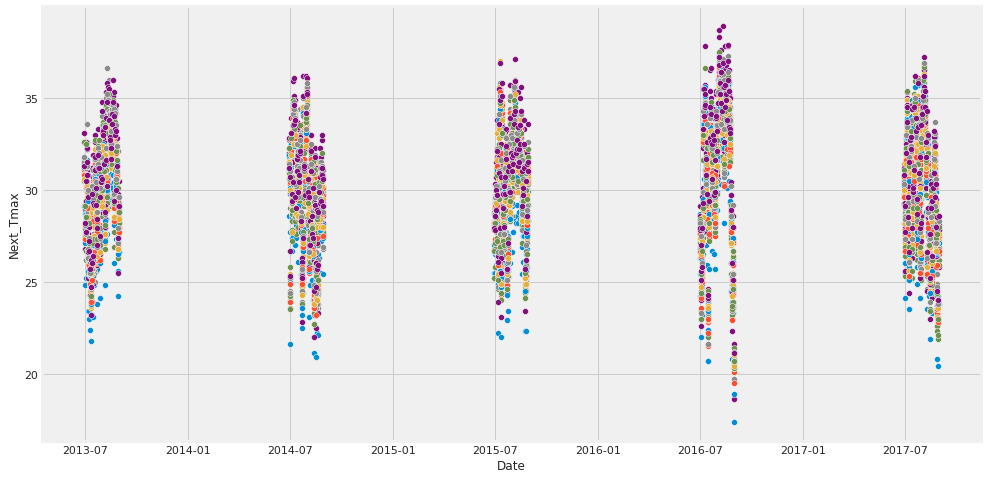

In [ ]:
#Conhecer a distribuição dos dados das estações no tempo
plt.figure(figsize=(15,8))
for i in range(25):
  sns.scatterplot(data=dataset.loc[dataset['station']==i],x='Date', y='Next_Tmax')

Aqui conseguimos observar um comportamento interessante, os dados parecem estar distribuídos do ano de 2013 até 2017, contudo, só temos dados próximos ao mês 07 de cada ano.

In [ ]:
#Vamos investigar os dados de uma estação
dataset.loc[dataset['station']==1]

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,2013-06-30,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,0.203896,0.161697,0.130928,0.000000,0.000000,0.000000,0.000000,37.6046,126.991,212.335,2.785,5992.895996,29.1,21.2
25,1.0,2013-07-01,28.3,21.2,72.798576,97.642792,25.276716,21.142562,15.608045,64.914946,0.615612,0.843199,0.810455,0.622040,0.804222,9.933111,0.237004,0.848082,37.6046,126.991,212.335,2.785,5987.718750,24.8,18.7
50,1.0,2013-07-02,24.4,20.6,55.647278,98.370041,27.785497,19.561770,11.168633,74.625920,0.312105,0.273683,0.030997,0.010617,0.000503,0.000000,0.000000,0.000000,37.6046,126.991,212.335,2.785,5981.979492,28.1,17.8
75,1.0,2013-07-03,27.9,17.9,76.017967,95.990532,28.125651,21.982579,10.546499,39.809905,0.187604,0.390579,0.438748,0.789554,0.000000,0.000000,0.000000,0.051695,37.6046,126.991,212.335,2.785,5975.676270,25.2,20.8
100,1.0,2013-07-04,24.9,21.5,55.888565,97.402481,30.458252,22.077078,7.393145,63.599636,0.814980,0.430494,0.160574,0.001116,0.096997,0.021871,0.000000,0.000000,37.6046,126.991,212.335,2.785,5968.809082,28.0,19.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7625,1.0,2017-08-26,25.2,18.1,51.869904,79.798698,23.725956,17.760520,5.794455,75.291540,0.076433,0.407909,0.429026,0.578956,0.000000,0.000000,0.000000,0.000000,37.6046,126.991,212.335,2.785,4769.281738,23.5,17.2
7650,1.0,2017-08-27,23.2,17.7,66.161346,96.971504,24.186341,19.262514,7.984710,69.810589,0.489156,0.502348,0.834759,0.814414,0.000000,0.000000,0.586814,6.179489,37.6046,126.991,212.335,2.785,4731.345215,24.2,15.9
7675,1.0,2017-08-28,23.2,16.0,37.498943,88.812614,21.253708,14.907923,13.977458,130.884057,0.372506,0.083947,0.053488,0.100585,0.000000,0.000000,0.000000,0.000000,37.6046,126.991,212.335,2.785,4692.945313,20.8,13.6
7700,1.0,2017-08-29,20.3,15.7,47.450760,87.877029,20.283129,14.272646,6.452666,68.709900,0.616098,0.648795,0.460766,0.092163,0.000000,0.000000,0.000000,0.000000,37.6046,126.991,212.335,2.785,4654.086426,20.4,14.6


In [ ]:
#Visualização geral das estatísticas do nosso dataset; 
dataset.describe()

,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
count,7682.000000,7682.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7725.000000,7725.000000
mean,29.768211,23.225059,56.759372,88.374804,29.613447,23.512589,7.097875,62.505019,0.368774,0.356080,0.318404,0.299191,0.591995,0.485003,0.278200,0.269407,37.544722,126.991397,61.867972,1.257048,5341.502803,30.274887,22.932220
std,2.969999,2.413961,14.668111,7.192004,2.947191,2.345347,2.183836,33.730589,0.262458,0.258061,0.250362,0.254348,1.945768,1.762807,1.161809,1.206214,0.050352,0.079435,54.279780,1.370444,429.158867,3.128010,2.487613
min,20.000000,11.300000,19.794666,58.936283,17.624954,14.272646,2.882580,-13.603212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.456200,126.826000,12.370000,0.098475,4329.520508,17.400000,11.300000
25%,27.800000,21.700000,45.963543,84.222862,27.673499,22.089739,5.678705,37.266753,0.146654,0.140615,0.101388,0.081532,0.000000,0.000000,0.000000,0.000000,37.510200,126.937000,28.700000,0.271300,4999.018555,28.200000,21.300000
50%,29.900000,23.400000,55.039024,89.793480,29.703426,23.760199,6.547470,56.865482,0.315697,0.312421,0.262555,0.227664,0.000000,0.000000,0.000000,0.000000,37.550700,126.995000,45.716000,0.618000,5436.345215,30.500000,23.100000
75%,32.000000,24.900000,67.190056,93.743629,31.710450,25.152909,8.032276,84.223616,0.575489,0.558694,0.496703,0.499489,0.052525,0.018364,0.007896,0.000041,37.577600,127.042000,59.832400,1.767800,5728.316406,32.600000,24.600000
max,37.600000,29.900000,98.524734,100.000153,38.542255,29.619342,21.857621,213.414006,0.967277,0.968353,0.983789,0.974710,23.701544,21.621661,15.841235,16.655469,37.645000,127.135000,212.335000,5.178230,5992.895996,38.900000,29.800000


Percebemos que temos dados faltando em algumas colunas já que o tamanho total do dataset é 7752, contudo isso representa < 0.1% no pior caso. Também é possível observar como se comporta a variável alvo(Next_Tmax).

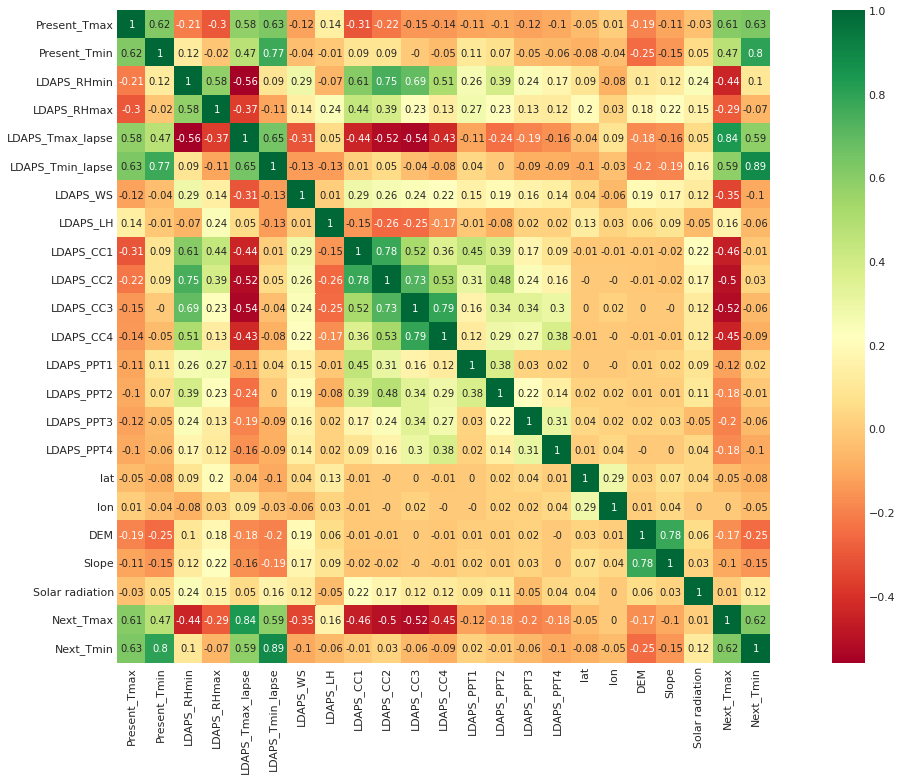

In [ ]:
#Identificar features que estão possivelmente correlacionadas linearmente.

plt.figure(figsize=(20,12))
sns.heatmap(dataset.corr().round(2),square=True,cmap="RdYlGn",annot=True)


As variaveis LDAPS_CCC é as que tem mais correlação.. podemos unir essas features nos modelos lineares para simplificação.
Conseguimos também identificar algumas variáveis que tem mais relação linear com a next Tmax

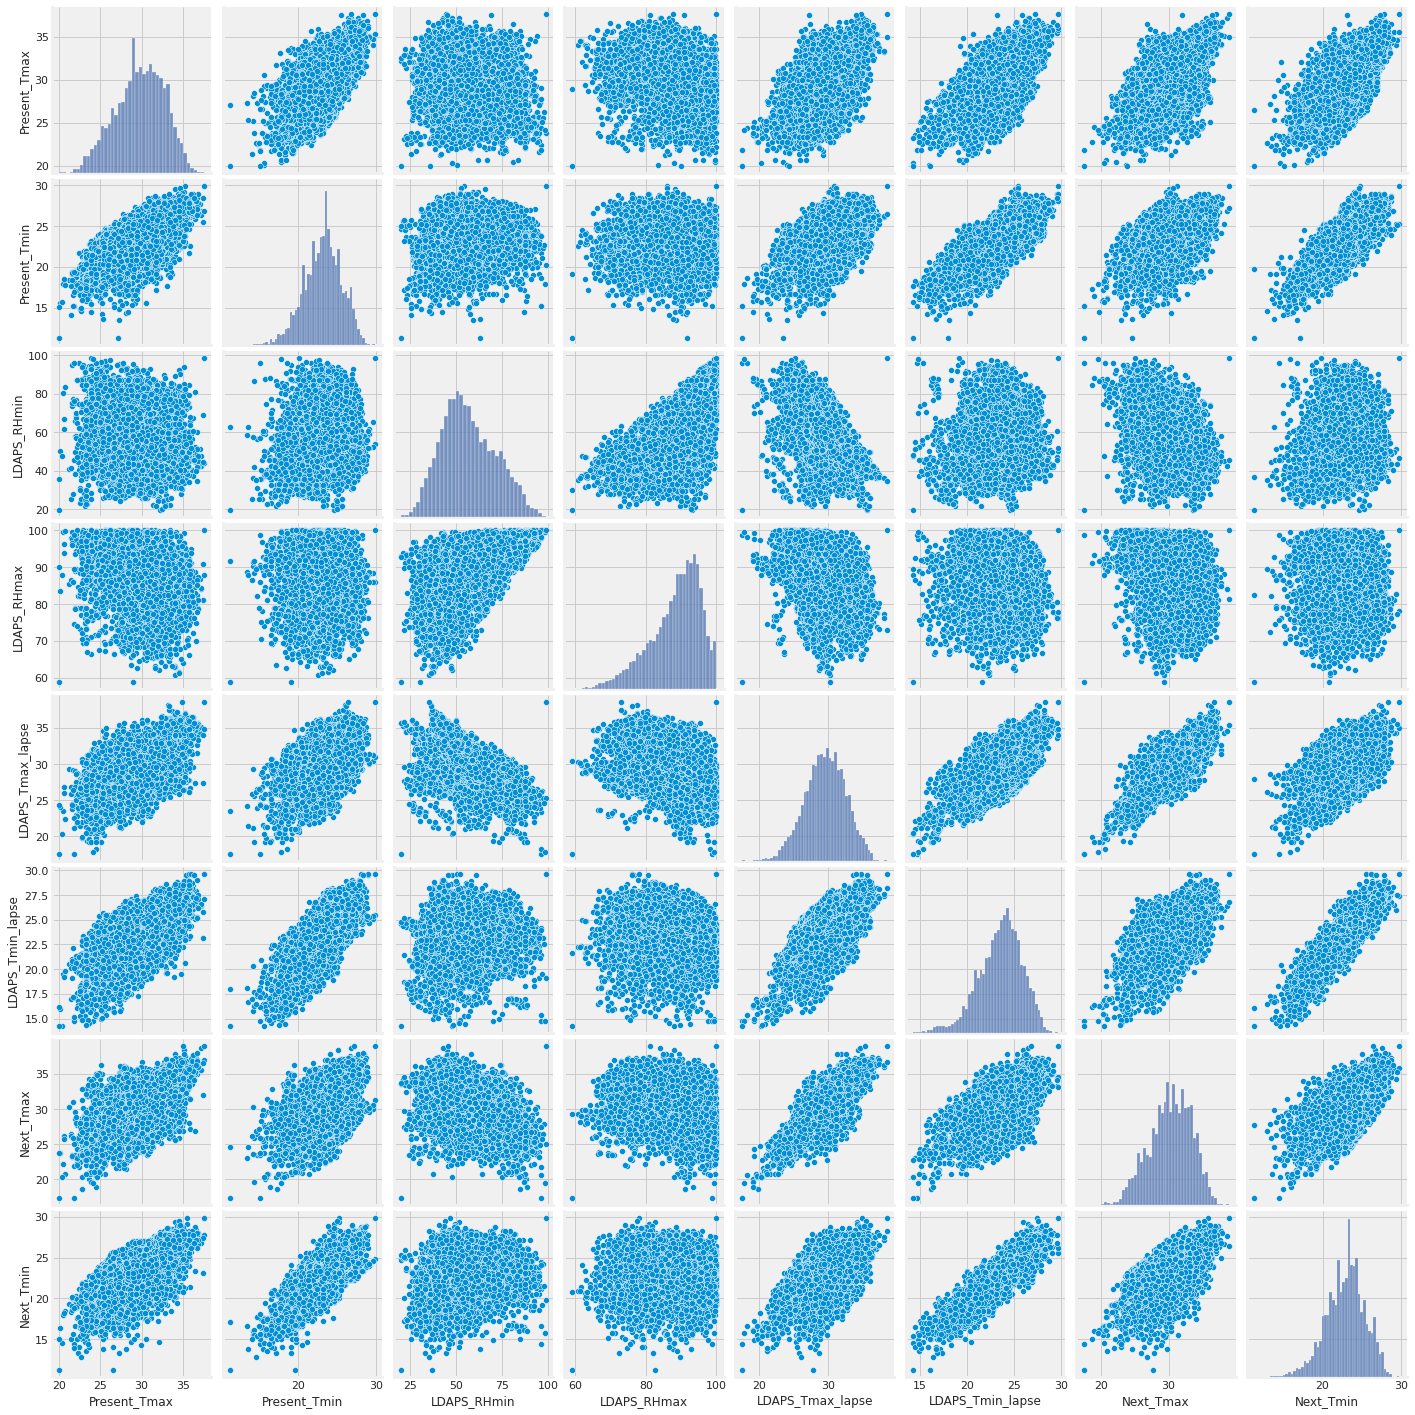

In [ ]:
#Vamos investigar outras possíveis correlações nas variáveis. 
#Testei todas mas vou apresentar aqui no notebook as que apresentaram alguma correlação 
#e queremos investigar melhor
df3 = dataset.loc[:, ("Present_Tmax","Present_Tmin","LDAPS_RHmin","LDAPS_RHmax","LDAPS_Tmax_lapse", "LDAPS_Tmin_lapse","Next_Tmax","Next_Tmin")]
x = sns.pairplot(df3)




Observamos algumas variáveis que apresentam potencial correlação linear mas não vamos fazer mais nenhuma simplificação no nosso dataset por enquanto

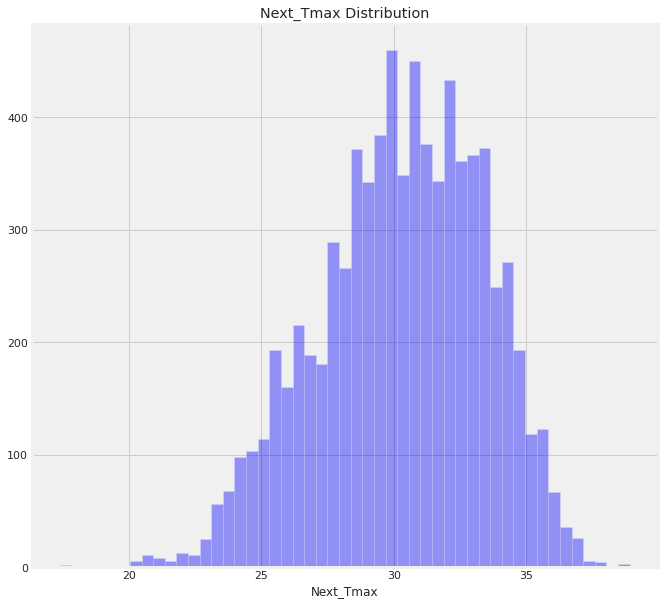

In [ ]:
# Distribuição da Variável Target
plt.figure(figsize=(10,10))
_ = sns.distplot(df3["Next_Tmax"], kde=False, color="blue")
_ = plt.title("Next_Tmax Distribution")

**2. Transformação das Features**

Nessa etapa vamos fazer algumas transformações no dataset para podermos treinar e avaliar os modelos de predição:



*  Primeiro ponto importante de se levantar no dataset. Não vamos utilizar a Feature Next_Tmin que se mostrou uma das variáveis mais relacionadas com o nosso Target. Vamos fazer isso pois essa variável não estaria disponível em um modelo de predição real de Next_tmax, já que as duas variáveis são obtidas ao mesmo tempo, evitando Data Leakage. 

* Treinei alguns modelos utilizando alternativas de one-hote-encode para tratar as estações como variáveis categóricas, porém, se tornaram modelos com alta dimensionalidade e com pior perfomance. Por conta disso, vamos dar outros tipos de tratamentos as estações, conforme é descrito no notebook.

* Como Lat, Lon, Slope e Dem são parâmetros função das estações, também não vamos utilizar para nos treinos

* Poderíamos tentar fazer uma imputação baseada na coordenada geográfica da estação mais próxima, contudo, para efeito de simplificação como temos
 menos de 0.01% dos dados faltando, vamos apenas deixar de usar essas linhas com dados omissos/NAN




In [ ]:
#LDAPS CC1,2,3 e 4 altamente correlacionados --> Transformar em uma feature
dataset['average_LDAPS_CC'] = dataset[['LDAPS_CC1', 'LDAPS_CC2','LDAPS_CC3','LDAPS_CC4']].mean(axis=1)
dataset

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,average_LDAPS_CC
0,1.0,2013-06-30,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,0.203896,0.161697,0.130928,0.000000,0.000000,0.000000,0.000000,37.6046,126.991,212.3350,2.785000,5992.895996,29.1,21.2,0.182617
1,2.0,2013-06-30,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,0.251771,0.159444,0.127727,0.000000,0.000000,0.000000,0.000000,37.6046,127.032,44.7624,0.514100,5869.312500,30.5,22.5,0.191113
2,3.0,2013-06-30,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,0.257469,0.204091,0.142125,0.000000,0.000000,0.000000,0.000000,37.5776,127.058,33.3068,0.266100,5863.555664,31.1,23.9,0.203257
3,4.0,2013-06-30,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,0.226002,0.161157,0.134249,0.000000,0.000000,0.000000,0.000000,37.6450,127.022,45.7160,2.534800,5856.964844,31.7,24.3,0.184445
4,5.0,2013-06-30,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,0.249995,0.178892,0.170021,0.000000,0.000000,0.000000,0.000000,37.5507,127.135,35.0380,0.505500,5859.552246,31.2,22.5,0.187579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7747,23.0,2017-08-30,23.3,17.1,26.741310,78.869858,26.352081,18.775678,6.148918,72.058294,0.030034,0.081035,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.5372,126.891,15.5876,0.155400,4443.313965,28.3,18.1,0.027767
7748,24.0,2017-08-30,23.3,17.7,24.040634,77.294975,27.010193,18.733519,6.542819,47.241457,0.035874,0.074962,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.5237,126.909,17.2956,0.222300,4438.373535,28.6,18.8,0.027709
7749,25.0,2017-08-30,23.2,17.4,22.933014,77.243744,27.939516,18.522965,7.289264,9.090034,0.048954,0.059869,0.000000,0.000796,0.000000,0.000000,0.000000,0.000000,37.5237,126.970,19.5844,0.271300,4451.345215,27.8,17.4,0.027405
7750,NaN,NaT,20.0,11.3,19.794666,58.936283,17.624954,14.272646,2.882580,-13.603212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.4562,126.826,12.3700,0.098475,4329.520508,17.4,11.3,0.000000


In [ ]:

#Tratar a estação como variável categórica
# Rodei alguns modelos tentando utilizar a estação como feature mas aumenta muito a dimensionalidade
# e reduz a importância de outras features, não resultando em um bom modelo final. Vamos tentar outras alternativas
#dataset = pd.get_dummies(dataset)

#Poderíamos tentar fazer uma imputação baseada na coordenada geográfica da estação mais próxima, contudo, para efeito de simplificação como temos
#menos de 0.01% dos dados missing, vamos apenas deixar de usar essas linhas com dados faltando/NAN
dataset = dataset.dropna()

dataset = dataset.drop(["LDAPS_CC1","LDAPS_CC2","LDAPS_CC3","LDAPS_CC4","lat","lon","DEM","Slope","Next_Tmin"],axis=1)



**Funções Auxiliares para deixar o nosso código mais limpo**
1. Transformar o dataset bruto nos dados de teste e treino
2. Métricas de Score que vamos utilizar para comparar nossos modelos de regressão
3. Função igual a 2 retornando os parâmetros
4. Plots do resultado dos *modelos*

In [ ]:
def transform_df(df):
  #Função para transformar nosso dataset nos dados de teste e treino
  #Treinar com dados até 2016 e testar na previsão em 2017
  Xtrain = df[(df['Date']< "2017-01-01")]
  Xtest = df[(df['Date']> "2017-01-01")]
  Ytrain = df["Next_Tmax"][(df['Date']< "2017-01-01")]
  Ytest = df["Next_Tmax"][(df['Date']> "2017-01-01")]
  Xtrain = Xtrain.drop(["Date","Next_Tmax","station"],axis=1)
  Xtest = Xtest.drop(["Date","Next_Tmax","station"],axis=1)
  Y = df["Next_Tmax"]
  return Xtrain,Xtest,Ytrain,Ytest,Y



In [ ]:
def scores(pipe,df):
  #Função que vai nos dar as métricas de avaliação da nossa regressão
  #Vamos utilizar 3 métricas: MAE, MSE e R2
  Xtrain,Xtest,Ytrain,Ytest,Y = transform_df(df)
  Y_pred = pipe.predict(Xtest)
  print("MAE:",mean_absolute_error(Y_pred,Ytest))
  print("MSE:",mean_squared_error(Y_pred,Ytest))
  print("R2:",pipe.score(df.drop(["Date","Next_Tmax","station"],axis=1),Y))


In [ ]:
def scores_s(pipe,df):
  #Função que vai nos retornar as métricas de avaliação da nossa regressão
  #Vamos utilizar 3 métricas: MAE, MSE e R2
  Xtrain,Xtest,Ytrain,Ytest,Y = transform_df(df)
  Y_pred = pipe.predict(Xtest)
  return mean_absolute_error(Y_pred,Ytest),mean_squared_error(Y_pred,Ytest),pipe.score(df.drop(["Date","Next_Tmax","station"],axis=1),Y)

In [ ]:
def model_plots(pipe,df):
  Xtrain,Xtest,Ytrain,Ytest,Y = transform_df(df)
  Y_pred = pipe.predict(Xtest)
  

  plt.figure(figsize=(12,12))

  plt.subplot(1, 2, 1) # row 1, col 2 index 1
  plt.scatter(Ytest, Y_pred, c='crimson')
  p1 = max(max(Y_pred), max(Ytest))
  p2 = min(min(Y_pred), min(Ytest))
  plt.plot([p1, p2], [p1, p2], 'b-')
  plt.xlabel('True Values', fontsize=15)
  plt.ylabel('Predictions', fontsize=15)
  plt.axis('equal')
  

  plt.subplot(1, 2, 2) # index 2
  #Regressões x Yield Real
  A = pd.Series.reset_index(Ytest)
  pd.Series(A['Next_Tmax']).plot()
  pd.Series(Y_pred).plot()
  plt.legend(['Real','Previsto'])
  plt.xlabel('X_Test', fontsize=15)
  plt.ylabel('Next_Tmax',fontsize=15);


  plt.show()


**3. Modelagem**

Aqui entramos em outro ponto importante. O desafio sugere uma modelagem utilizando métricas obrigatórias como Recall, Precisão e Acuraccy. Essas métricas são fundamentais para entender um modelo de classificação e analisar sua perfomance dependendo da especificidade da nossa aplicação. Seria até possível modelarmos esse problema como um problema de classificação, discretizando as classes de previsão. Contudo, escolhi fazer uma modelagem para previsão da variável target de forma contínua, optando por utilizar modelos de regressão.

Testei alguns outros modelos de regressão utilizando o framework TensorFlow, mas por termos poucos dados para treinar as redes neurais, vamos utilizar aqui como baseline os modelos de regressão do pacote Sklearn.

In [ ]:
#Função com as transformações do dataset
Xtrain,Xtest,Ytrain,Ytest,y = transform_df(dataset)

LR: -1.206781 (0.173482)
RF: -1.311115 (0.165162)
SVR: -2.638313 (0.640128)
EL: -1.551515 (0.543196)
GBR: -1.293000 (0.185980)


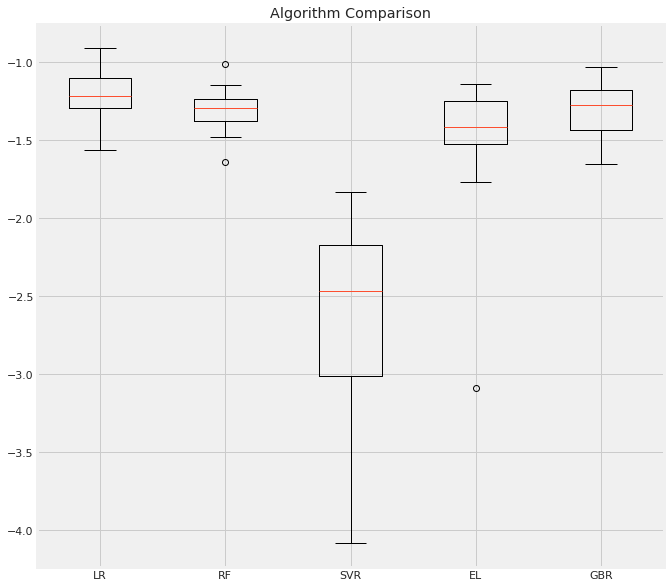

In [ ]:
# Comparar perfomance dos algoritmos de regressão
models = []
models.append(('LR', LinearRegression()))
models.append(('RF', RandomForestRegressor())) 
models.append(('SVR', SVR(gamma='auto'))) 
models.append(('EL',ElasticNet()))
models.append(('GBR',GradientBoostingRegressor(loss='absolute_error')))

# Avaliar cada modelo 
results = []
names = []
for name, model in models:
 # TimeSeries Cross validation - Não podemos utilizar K-Fold para validar um modelo temporal
 tscv = TimeSeriesSplit(n_splits=10)
    
 cv_results = cross_val_score(model, Xtrain, Ytrain, cv=tscv, scoring='neg_mean_absolute_error')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Plot Final
plt.figure(figsize=(10,10))
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

Os menores erros absolutos foram observados nos modelos de Regressão Linear, Random Forest e XgBost. Vamos testar primeiro o modelo linear para avaliar a importância das features.  

In [ ]:
# Pipeline Objects
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()
linear_regression = LinearRegression(n_jobs=-1)
GBR_model = GradientBoostingRegressor(max_depth=5, n_estimators=15,loss='absolute_error');
#Manter a dimensão das features para avaliar a importância
poly = PolynomialFeatures(degree=1,interaction_only=True)

In [ ]:
pipe = make_pipeline(imputer, scaler, poly, linear_regression)
pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(degree=1, interaction_only=True)),
                ('linearregression', LinearRegression(n_jobs=-1))])

MAE: 1.2862701182313854
MSE: 3.0408358062593215
R2: 0.7698145596890755


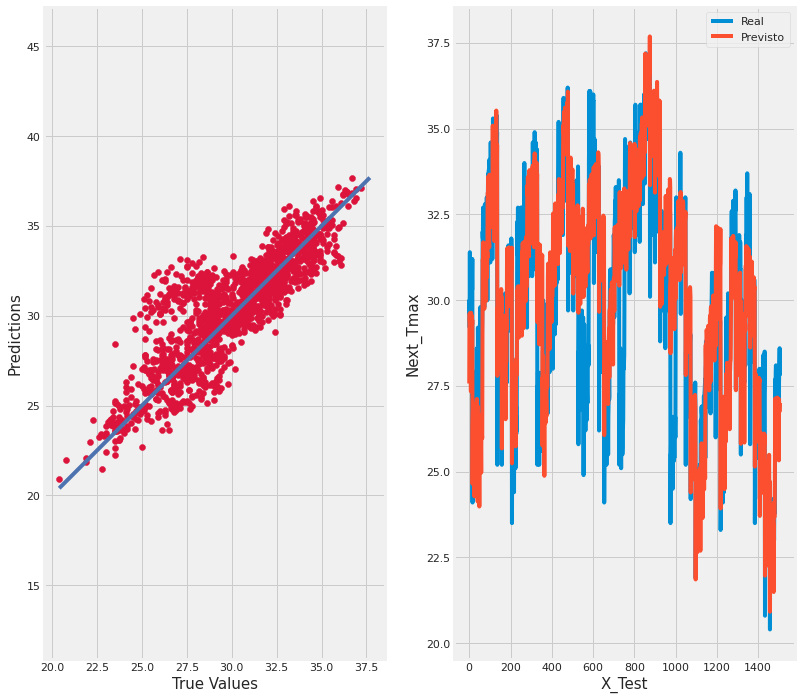

In [ ]:
# Fit
pipe.fit(Xtrain, Ytrain)
scores(pipe,dataset)
model_plots(pipe,dataset)

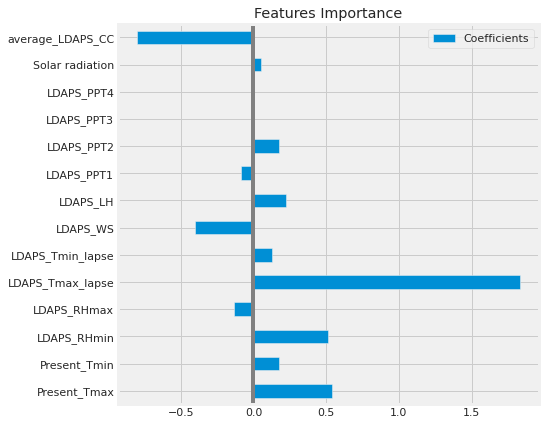

In [ ]:
#Checar a importância das features no modelo inicial

coefs = pd.DataFrame(
   pipe[3].coef_[1:],
   columns=['Coefficients'], index=Xtrain.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Features Importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Conseguimos observar que algumas features praticamente não tem peso para a nossa modelagem da variável target. Vamos trabalhar apenas com as features mais importantes para ver se conseguimos ter o mesmo resultado com um modelo mais simples

In [ ]:


dataset2 = dataset[['station','LDAPS_RHmin','LDAPS_LH','average_LDAPS_CC','LDAPS_Tmin_lapse','LDAPS_Tmax_lapse','Present_Tmax','Present_Tmin','LDAPS_WS',"Date","Next_Tmax"]]
dataset2.head()



,station,LDAPS_RHmin,LDAPS_LH,average_LDAPS_CC,LDAPS_Tmin_lapse,LDAPS_Tmax_lapse,Present_Tmax,Present_Tmin,LDAPS_WS,Date,Next_Tmax
0,1.0,58.255688,69.451805,0.182617,23.006936,28.074101,28.7,21.4,6.818887,2013-06-30,29.1
1,2.0,52.263397,51.937448,0.191113,24.035009,29.850689,31.9,21.6,5.691890,2013-06-30,30.5
2,3.0,48.690479,20.573050,0.203257,24.565633,30.091292,31.6,23.3,6.138224,2013-06-30,31.1
3,4.0,58.239788,65.727144,0.184445,23.326177,29.704629,32.0,23.4,5.650050,2013-06-30,31.7
4,5.0,56.174095,107.965535,0.187579,23.486480,29.113934,31.4,21.9,5.735004,2013-06-30,31.2


In [ ]:
Xtrain2,Xtest2,Ytrain2,Ytest2,y2 = transform_df(dataset2)

In [ ]:
# Fit
pipe.fit(Xtrain2, Ytrain2)
scores(pipe,dataset2)

MAE: 1.2760510356012267
MSE: 3.014577404586486
R2: 0.7671998835530036


Nossas métricas continuam praticamentes as mesmas com apenas 8 features. Já é um bom avanço da lista das 22 iniciais

**4. Feature Engineering**

Durante a etapa de Feature Engineering, temos o objetivo de criar algumas features que podem impactar positivamente no nosso modelo:



*   Vamos gerar uma lista da combinação de 5 features 2 a 2 que podem potencialmente impactar o nosso modelo positivamente
*   Como estamos trabalhando com uma série temporal, vamos trabalhar com a média movel da variável target como uma possível feature e observar o impacto nas métricas



In [ ]:
#Possiveis Features 2 a 2
columns_list = Xtrain2.columns
interactions = list(combinations(columns_list, 2))

In [ ]:
#Adição da nova feature e regressão
interaction_dict = {}
for interaction in interactions:
   X_train_int = Xtrain2
   X_train_int['int'] = X_train_int[interaction[0]] * X_train_int[interaction[1]]
   lr = LinearRegression()
   lr.fit(X_train_int, Ytrain2)
   interaction_dict[lr.score(X_train_int, Ytrain2)] = interaction

In [ ]:
#Lista com as 5 features combinadas que mais impactaram o modelo
top_5 = sorted(interaction_dict.keys(), reverse = True)[:5]
for interaction in top_5:
   print(interaction_dict[interaction])

('Present_Tmax', 'Present_Tmin')
('average_LDAPS_CC', 'Present_Tmax')
('average_LDAPS_CC', 'LDAPS_Tmax_lapse')
('average_LDAPS_CC', 'LDAPS_Tmin_lapse')
('LDAPS_Tmin_lapse', 'LDAPS_WS')


In [ ]:
#Adicionando as novas features ao dataset
dataset2['f1'] = dataset2['Present_Tmin'] * dataset2['Present_Tmax']
dataset2['f2'] = dataset2['average_LDAPS_CC'] * dataset2['LDAPS_Tmin_lapse']
dataset2['f3'] = dataset2['average_LDAPS_CC'] * dataset2['LDAPS_Tmax_lapse']
dataset2['f4'] = dataset2['LDAPS_Tmin_lapse'] * dataset2['LDAPS_WS']
dataset2['f5'] = dataset2['Present_Tmax'] * dataset2['average_LDAPS_CC']

In [ ]:
Xtrain3,Xtest3,Ytrain3,Ytest3,y3 = transform_df(dataset2)

In [ ]:
pipe.fit(Xtrain3, Ytrain3)
scores(pipe,dataset2)

MAE: 1.36347960805293
MSE: 3.409489060007118
R2: 0.7661957979345715


Não acrescentou muito a nosso modelo... Vamos testar agora a média móvel

In [ ]:
#Utilizando a feature da média movel por estação nos útlimos 3 dias
# Média das Tmax dos últimos 3 dias por estação tem relação com a Tmax prevista?
dataset3 = dataset[['station','LDAPS_RHmin','LDAPS_LH','average_LDAPS_CC','LDAPS_Tmin_lapse','LDAPS_Tmax_lapse','Present_Tmax','Present_Tmin','LDAPS_WS',"Date","Next_Tmax"]]
dataset3['mTmax3'] = dataset3.groupby('station')['Present_Tmax'].transform(lambda x: x.rolling(3, 1).mean())

In [ ]:
Xtrain3,Xtest3,Ytrain3,Ytest3,y3 = transform_df(dataset3)

MAE: 1.2690484150563377
MSE: 2.9807274436021305
R2: 0.7693674377822304


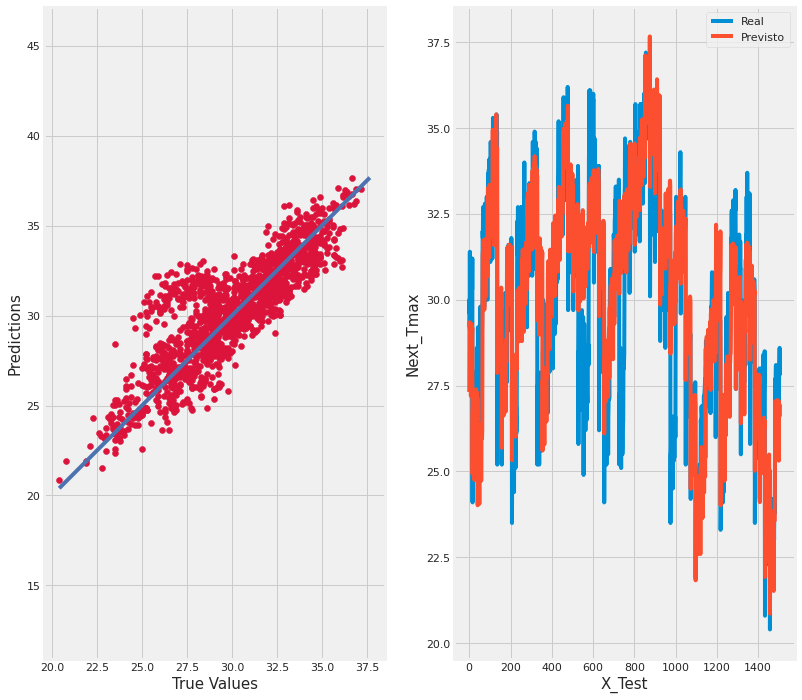

In [ ]:
pipe.fit(Xtrain3, Ytrain3)
scores(pipe,dataset3)
model_plots(pipe,dataset3)

Agora sim observamos uma melhora na perfomance do nosso modelo, superando inclusive o inicial com todas as features :)

**5. Trabalhando com o modelo de regressão por Estação**

Como observamos inicialmente, uma possível fonte de erro em nosso modelo é a utilização de dados de uma estação para estimar os dados em outro lugar (ou na média do município). 

Como já foi dito, tentei trabalhar inicialmente os dados das estações de forma categórica diretamente na regressão, mas resultou em um modelo com alta dimensionalidade e perdi a sensibilidade de outras features na variável target.

Estamos trabalhando com equipamentos que estão distribuidos ao longo da geografia de uma cidade e podem realmente apresentar leituras diferentes (Ex: Temperatura menor registrada em um ponto mais alto da cidade).
Para tentar eliminar esse tipo de erro do nosso modelo, vamos fazer um modelo de regressão para cada estação, dando a possibilidade de estimar a nossa variável target em diferentes pontos da cidade

In [ ]:
#Teste da regressão linear apenas com os dados da estação 1
dataset4 = dataset3.loc[dataset['station']==1]
Xtrain4,Xtest4,Ytrain4,Ytest4,y4 = transform_df(dataset4)

MAE: 1.083580490505149
MSE: 2.1760547526786818
R2: 0.8014908853374143


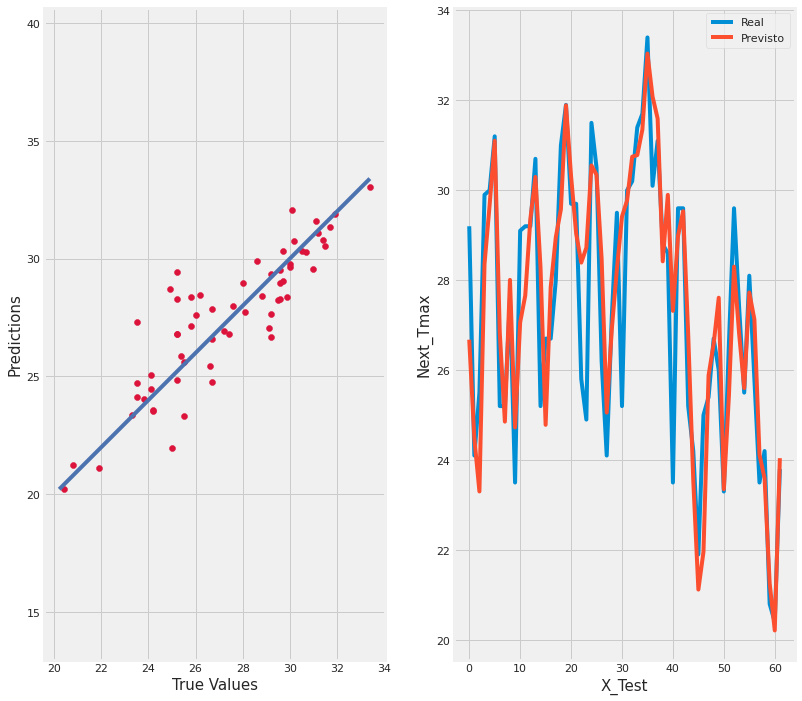

In [ ]:
pipe.fit(Xtrain4, Ytrain4)
scores(pipe,dataset4)
model_plots(pipe,dataset4)

Olha só... como podemos observar conseguimos métricas bem melhores para a estação 1 comparado ao nosso modelo com todas as estações. Logicamente não podemos comparar as métricas dos dois modelos diretamente, contudo, temos um sinal de que se individualizarmos o problema podemos obter melhores regressões. Vamos fazer uma otimização dos hiperparâmetros da pipeline para ver se conseguimos melhorar ainda mais

In [ ]:
#Otimização de Hiperparâmetros em nossa pipeline Regressão Linear
params = {}
params["simpleimputer"] = [None, SimpleImputer()]
params["standardscaler"] = [None, StandardScaler(), MinMaxScaler()]
params["polynomialfeatures"] = [None, PolynomialFeatures(4)]
# Gridsearch
grid = GridSearchCV(pipe, params, cv= TimeSeriesSplit(n_splits=10))
grid.fit(Xtrain4, Ytrain4)
best_estimator = grid.best_estimator_
preds = best_estimator.predict(Xtest4)
print("MAE:",mean_absolute_error(preds,Ytest4))
print("MSE:",mean_squared_error(preds,Ytest4))

MAE: 1.0835804905051492
MSE: 2.1760547526786835


Com os hiperparâmetros da pipeline testados não conseguimos melhorar nossas métricas de erro. Vamos fazer a regressão linear para as 25 estações e analisar as métricas encontradas

In [ ]:
#Inicialização da matriz dos erros
M = np.zeros((25, 3))
L = range(1,26)

#Acumulado de todas as estações para a métrica global
y_true = [];
y_pred = [];

#Regressão para cada estação
for i in L:

  dfx = dataset3.loc[dataset['station']==i]
  Xtrain,Xtest,Ytrain,Ytest,y = transform_df(dfx)
  pipe.fit(Xtrain, Ytrain)
  #Variável para guardar o Y_pred de cada pipeline
  acc = pipe.predict(Xtest)
  #Pra fazer o plot individualizado dos scores
  M[i-1,0],M[i-1,1],M[i-1,2] = scores_s(pipe,dfx)

  #Conjunto de dados pequenos, não vai ter interferência na perfomance de nosso modelo o for dentro do for (o^2).
  #Pra testar o score global
  for j in acc:
    y_pred.append(j)
  
  for k in Ytest:
    y_true.append(k)


#Valor médio de MAE, MSE e R2 - Conseguimos algum avanço trabalhando por estação..
#Vamos visualizar os dados
print("MAE:", mean_absolute_error(y_pred,y_true))
print("MSE:", mean_squared_error(y_pred,y_true))


MAE: 1.195380771772136
MSE: 2.766848828003984


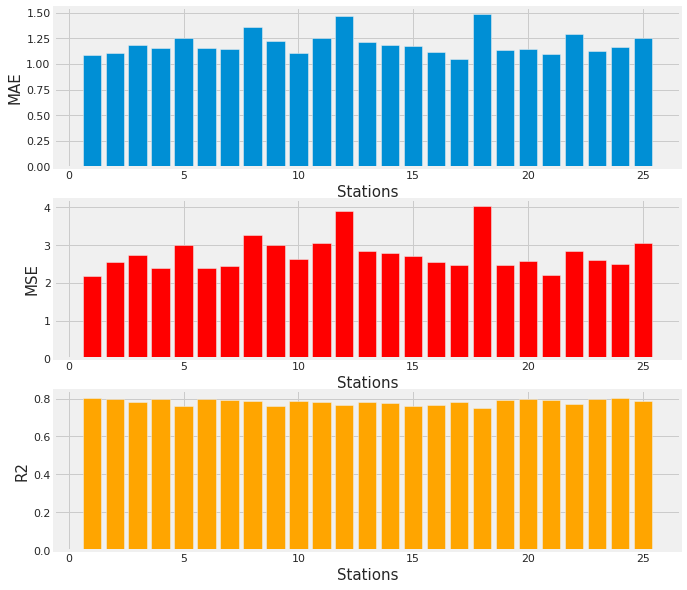

In [ ]:
#Plot das métricas encontradas
plt.figure(figsize=(10,10))

plt.subplot(3, 1, 1) 
plt.bar(L,M[:,0])
plt.xlabel('Stations', fontsize=15)
plt.ylabel('MAE', fontsize=15)
  

plt.subplot(3, 1, 2) 
plt.bar(L,M[:,1],color = "red")
plt.xlabel('Stations', fontsize=15)
plt.ylabel('MSE', fontsize=15)
  

plt.subplot(3, 1, 3) 
plt.bar(L,M[:,2],color = "orange")
plt.xlabel('Stations', fontsize=15)
plt.ylabel('R2', fontsize=15)

plt.show()

Conseguimos identificar que em 4 estações(8,12,18,22) temos valores de MAE e MSE acima da média das demais. Poderíamos investigar mais criteriosamente estas estações para avaliar o impacto das imprecisões provocadas por elas no modelo final. 

Além disso, conseguimos resultados muito bons com o modelo de regressão linear(OLS), com um erro absoluto(MAE) de 1.19, reduzindo em cerca de 7% o nosso erro absoluto inicial. O caminho da modelagem por estação se mostra bem promissor e poderíamos investir mais tempo testando outros modelos, frameworks e otimização de hiperparâmetors. 

Para finalizar nossa verificação, vamos testar o segundo modelo de regressão mais bem colocado nos nossos testes iniciais (XGBoost), dessa vez otimizando seus hiperparâmetros para cada regressão nas estações.



In [ ]:
#Teste da regressão com Gradient Boosting
pipe = make_pipeline(imputer, scaler, poly, GBR_model)


In [ ]:
M = np.zeros((25, 3))
L = range(1,26)

#Acumulado de todas as estações para a métrica global
y_true = [];
y_pred = [];

for i in L:

  dfx = dataset3.loc[dataset['station']==i]
  Xtrain,Xtest,Ytrain,Ytest,y = transform_df(dfx)
  pipe.fit(Xtrain, Ytrain)
  #Variável para guardar o Y_pred de cada pipeline
  acc = pipe.predict(Xtest)
  M[i-1,0],M[i-1,1],M[i-1,2] = scores_s(pipe,dfx)

  #Conjunto de dados pequenos, não vai ter interferência na perfomance de nosso modelo o for dentro do for (O^2).
  #Pra testar o score global
  for j in acc:
    y_pred.append(j)
  
  for k in Ytest:
    y_true.append(k)


#Valor médio de MAE, MSE e R2 - Conseguimos algum avanço trabalhando por estação..
#Vamos visualizar os dados
print("MAE:", mean_absolute_error(y_pred,y_true))
print("MSE:", mean_squared_error(y_pred,y_true))


MAE: 1.4745874000523724
MSE: 3.729204250656677


In [ ]:
#Hyperparameter Tuning Regressão Gradient Boosting
#Teste para a estação 1

param_grid = {'gradientboostingregressor__n_estimators': [3, 8,10,15],
              'gradientboostingregressor__max_depth': [3, 5, 8, 10],
              'gradientboostingregressor__loss':['squared_error', 'absolute_error']}

grid = GridSearchCV(pipe, param_grid, cv= TimeSeriesSplit(n_splits=10))

grid.fit(Xtrain4, Ytrain4)

best_estimator = grid.best_estimator_
preds = best_estimator.predict(Xtest4)
print("MAE:",mean_absolute_error(preds,Ytest4))
print("MSE:",mean_squared_error(preds,Ytest4))

MAE: 1.3010769540726221
MSE: 2.507062043781703


Percebemos que a regressão linear(OLS) ainda obteve erros mais baixos (MAE e MSE) mesmo otimizando os hiperparâmetros escolhidos da regressão Gradient Boosting (Aqui comparei apenas a regressão otimizada da estação 1). Além disso, é um modelo bastante simples e com fácil interpretação das features. **Assim, a minha sugestão como modelo baseline para trabalhar com a previsão da variável Next_Tmax seria a regressão linear(OLS) para cada estação.**

**6. Passos com mais tempo disponível:**


*   Testar e otimizar os hiperparâmetros de outras regressões não lineares que apresentaram bom potencial na análise inicial => Ex: Random Forest. Variar também os hiperparâmetros utilizados para otimização.
* Testar o modelo de regressão para outros modelos estado da arte fora do pacote Scikit-learn: XGBost
* Buscar outras técnicas de feature engineering (Ex: PCA, Target Encoding para as stations[categórica]) que podem potencializar os modelos propostos e até mesmo o modelo baseline OLS
*   Tratar o problema como uma classificação para ter métricas de precision e recall e ter alternativas de uso do modelo em outros cenários : Exemplo: Queremos um modelo que com alta capacidade em identificar temperaturas maiores que um valor T, mas não ligamos se ele não for específico em classes menores do que esse valor T



*Extra: Como avaliação extra, vamos realizar uma regressão multitarget analisando também o comportamento de Next_Tmin. Para isso vamos utilizar um modelo que nativamente suporta regressões multitarget, como o modelo baseado em árvores de decisão - Random Forest

In [ ]:
#Vamos utilizar o conjunto inicial de features global já que precisaríamos otimizar com as 2 targets
dataset5 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00514/Bias_correction_ucl.csv')

dataset5 = dataset5.dropna()

dataset5 = dataset5.drop(["lat","lon","DEM","Slope"],axis=1)

Xtrain5 = dataset5[(dataset5['Date']< "2017-01-01")]
Xtest5 = dataset5[(dataset5['Date']> "2017-01-01")]
Ytrain5 = dataset5[["Next_Tmax","Next_Tmin"]][(dataset5['Date']< "2017-01-01")]
Ytest5 = dataset5[["Next_Tmax","Next_Tmin"]][(dataset5['Date']> "2017-01-01")]
Xtrain5 = Xtrain5.drop(["Date","Next_Tmax","Next_Tmin","station"],axis=1)
Xtest5 = Xtest5.drop(["Date","Next_Tmax","Next_Tmin","station"],axis=1)

model = RandomForestRegressor()
model.fit(Xtrain5, Ytrain5)
score = model.score(Xtest5, Ytest5)
print("MAE:",mean_absolute_error(model.predict(Xtest5),Ytest5))
print("MSE:",mean_squared_error(model.predict(Xtest5),Ytest5))
print("R2:",score)

MAE: 1.0832466799468776
MSE: 2.2210412480079675
R2: 0.7494393232966421


Olha só.. o modelo de predição multitarget acabou supreendendo bem os menores valores de MAE e MSE. Teríamos que ter mais tempo para analisar esse resultado, mas uma possível explicação é que nosso modelo consegue prever melhor o Next_Tmin e os scores globais acabaram diminuindo.

Não chegamos também a testar o Random Forest com os hiperparâmetros otimizados e isso pode nos dar mais uma dica que é um modelo que vale a pena investir.